In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score

In [2]:
data = fetch_california_housing()

In [3]:
#df = pd.DataFrame()

In [4]:
len(data.data)

20640

In [5]:
np.random.seed(0)
data_points = np.random.permutation(range(len(data.data)))
X = data.data[data_points[:1000],:]
y = data.target[data_points[:1000]]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 8), (200, 8), (800,), (200,))

## Fit a fully grown tree

In [8]:
rt = DecisionTreeRegressor(random_state=0)
rt.fit(X=X_train, y=y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [9]:
R2_train = rt.score(X_train, y_train)
R2_test = rt.score(X_test, y_test)
print('Training R2:', R2_train)
print('Test R2:', R2_test)

Training R2: 1.0
Test R2: 0.40749181069191365


In [10]:
print('Tree depth:', rt.tree_.max_depth)
print('Tree node count:', rt.tree_.node_count)

Tree depth: 21
Tree node count: 1543


In [11]:
# plt.figure(figsize=(15,15))
# print(plot_tree(rt, fil
# led=True, fontsize=8))

## Cost complexity Prunning

In [12]:
path = rt.cost_complexity_pruning_path(X_train, y_train)

In [13]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [14]:
# ccp_alphas, impurities

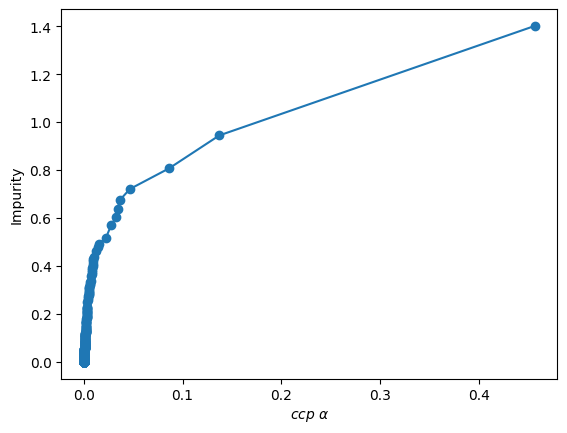

In [15]:
plt.plot(ccp_alphas, impurities, marker = 'o')
plt.xlabel(r'$ccp~\alpha$')
plt.ylabel('Impurity')
plt.show()

In [16]:
# Remove the last tree (only root), not useful for accuracy
ccp_alphas = np.unique(ccp_alphas)[:-1]

In [17]:
cv_r2 = []  # Store results

# Compute cross-validated avg MSE for each candidate ccp_alpha
for alpha in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=0, ccp_alpha=alpha)
    scores = cross_val_score(dt, X_train, y_train, cv=KFold(5, shuffle=True, random_state=0), 
                             scoring='r2', n_jobs=-1)
    cv_r2.append(np.mean(scores))

In [18]:
len(cv_r2)

713

In [19]:
# Choose best alpha
best_alpha = ccp_alphas[np.argmax(cv_r2)]
print("Best alpha:", best_alpha)
print("maximum CV_R2:", np.max(cv_r2))

Best alpha: 0.01278710155440857
maximum CV_R2: 0.5239557971785835


Text(0, 0.5, 'Avg CV $R^2$')

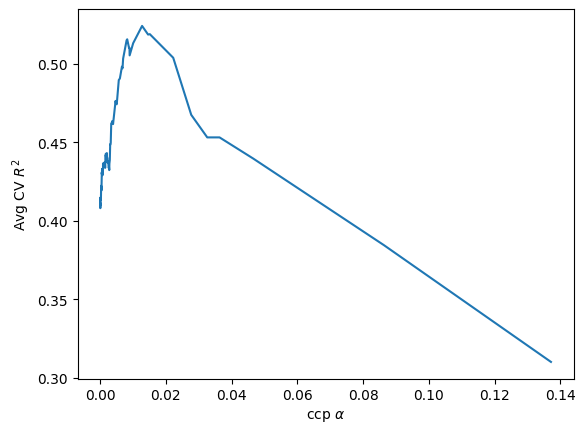

In [20]:
plt.plot(ccp_alphas, cv_r2)
plt.xlabel(r'ccp $\alpha$'); plt.ylabel(r'Avg CV $R^2$')

## Final Tree

In [32]:
# Fit final model with best alpha
final_tree = DecisionTreeRegressor(random_state=0, ccp_alpha= 0.01279)
final_tree.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.01279


In [47]:

print('******** Final tree results ********')
print('Training R2:', final_tree.score(X_train, y_train))
print('Test R2:', final_tree.score(X_test, y_test))
print('Tree depth:', final_tree.tree_.max_depth)
print('Tree node count:', final_tree.tree_.node_count)

******** Final tree results ********
Training R2: 0.6690777120484872
Test R2: 0.4910428023362693
Tree depth: 6
Tree node count: 25


## Some diagrams

In [34]:
clfs = []
for alpha in ccp_alphas:
    clf = DecisionTreeRegressor(ccp_alpha=alpha, random_state=0)
    clf.fit(X_train, y_train)
    clfs.append(clf)

In [35]:
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

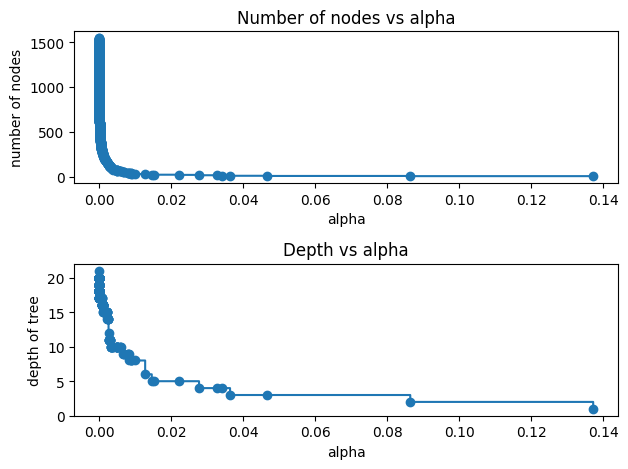

In [36]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Plotting train and test R2 for various prunned subtrees

In [37]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

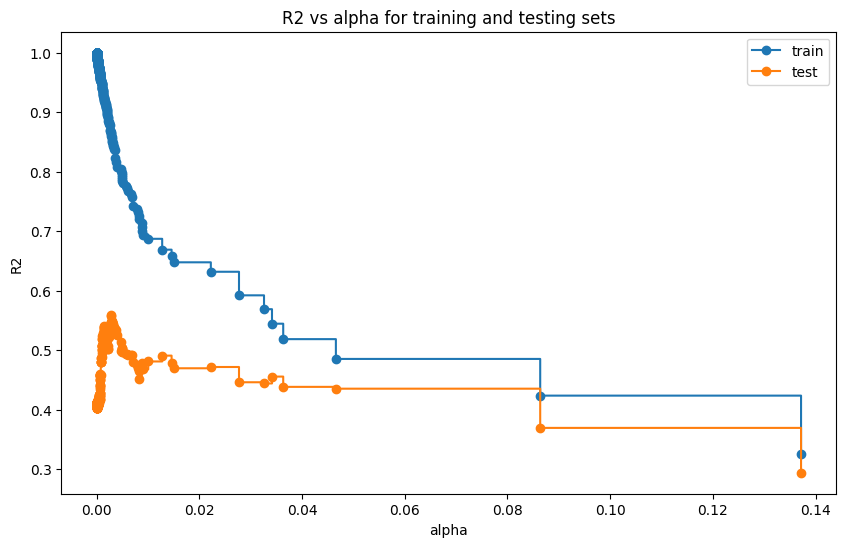

In [38]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("alpha")
ax.set_ylabel("R2")
ax.set_title("R2 vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [39]:
AA = pd.DataFrame({'node_counts':node_counts, 
                   'depth': depth, 
                   'train_scores': train_scores, 
                   'test_scores': test_scores, 
                   'ccp_alphas': ccp_alphas,
                   'cv':cv_r2})
AA.iloc[np.append(0,np.arange(325,335)), :]

,node_counts,depth,train_scores,test_scores,ccp_alphas,cv
0,1543,21,1.000000,0.407492,0.000000,0.412381
325,871,18,0.998904,0.409824,0.000022,0.411371
326,869,18,0.998888,0.409824,0.000022,0.411371
327,867,18,0.998873,0.410561,0.000022,0.411257
328,863,18,0.998841,0.410324,0.000022,0.411258
329,861,18,0.998825,0.411844,0.000023,0.411317
330,859,18,0.998808,0.411111,0.000023,0.411620
331,857,18,0.998791,0.411623,0.000024,0.411620
332,855,18,0.998775,0.411623,0.000024,0.411620
333,853,18,0.998758,0.411034,0.000024,0.411620


## Linear regression

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
model = LinearRegression()
model.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [42]:
print('*********Linear regression scores*********')
print('Train MSE: ', model.score(X_train, y_train))
print('Test MSE: ', model.score(X_test, y_test))

*********Linear regression scores*********
Train MSE:  0.6400305668031624
Test MSE:  0.5863264047398461
